<a href="https://colab.research.google.com/github/mirwisek/frame-selection-activenerf/blob/main/tiny_nerf_pytorch_rizwan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **For Rizwan**

## Tiny NeRF (A PyTorch implementation)

So, this weekend, I was catching up on this _cool paper_ titled [*NeRF: Representing scenes as neural radiance fields for view synthesis*](https://arxiv.org/abs/2003.08934)!

The authors released a TensorFlow implementation [here](https://github.com/bmild/nerf). Deciding to delve deeper, I ported their code to PyTorch, cause why not!

> *DISCLAIMER*: This notebook (and repository) is work-in-progress. Although I have rigorously tested most modules in here (to faithfully replicate the original implementation), my implementation at places deviates from the authors'. Comments/criticism welcome!

> All functions that have a `#TESTED` under the docstring imply that they have been tested against their corresponding tensorflow impls.

In [21]:
# !pip3 -q install umap-learn
# !pip3 -q install hdbscan
# !pip3 -q install lpips
# !pip3 -q install torchmetrics
# !pip3 -q install optuna

In [22]:
# Import all the good stuff
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

## A few utility functions

In [23]:
from model import VeryTinyNerfModel
from image_encoder import ImageEncoder
from data_utils import load_tiny_nerf_data, load_nerf_data, get_focal_length
from nerf_utils import positional_encoding, get_minibatches, run_one_iter_of_tinynerf
from utils import select_frames_from_baseline, select_frames_from_clustering, calculate_lpips, calculate_ssim

In [30]:
experiment_data_type = "tiny_nerf"
experiment_data_type = "nerf_synthetic"
nerf_test_subject = "lego" 
nerf_subjects_list = ['ship', 'drums', 'ficus', 'hotdog', 'lego', 'materials', 'mic', 'chair']

tiny_data_path = "data/tiny_nerf_data.npz"
nerf_synthetic_path = "data/nerf_synthetic"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if experiment_data_type == "tiny_nerf":
    logs_path = f"logs/{experiment_data_type}"
else:
    logs_path = f"logs/{experiment_data_type}/{nerf_test_subject}"

## Get data

In [31]:
# Download sample data used in the official tiny_nerf example
if not os.path.exists(tiny_data_path):
    !wget -P data/ http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

## Load up input images, poses, intrinsics, etc.

In [32]:
# Near and far clipping thresholds for depth values.
near_thresh = 2.
far_thresh = 6.

# Height and width of each image
height, width = 100, 100

if experiment_data_type == "tiny_nerf":
    images, tform_cam2world, focal_length, testimgs, testposes = load_tiny_nerf_data(tiny_data_path, device)
else:
    images, train_poses, camera_angle_x = load_nerf_data(nerf_synthetic_path, nerf_test_subject, 'transforms_train.json')
    tform_cam2world = train_poses

    focal_length = get_focal_length(width, camera_angle_x)
    focal_length = torch.from_numpy(focal_length)

    # Hold one image out (for test).
    testimgs, testposes, _ = load_nerf_data(nerf_synthetic_path, nerf_test_subject, 'transforms_test.json', skip_images=20)

    testimgs = testimgs.to(device)
    testposes = torch.from_numpy(testposes).to(device)

    # # Map images to device
    images = images.to(device)
    tform_cam2world = torch.from_numpy(tform_cam2world[:100,]).to(device)

#### Display the image used for testing

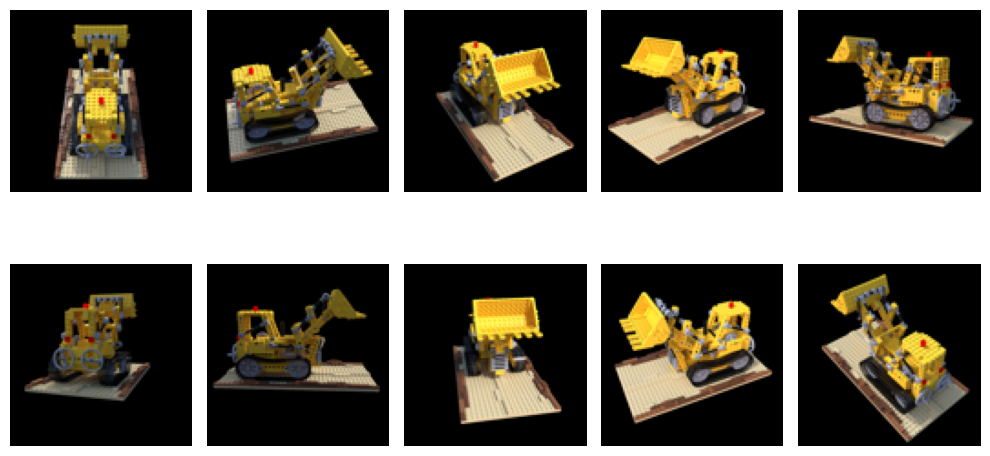

In [33]:
if experiment_data_type == "tiny_nerf":
    fig, axs = plt.subplots(2, 3, figsize=(10, 6))
else:
    fig, axs = plt.subplots(2, 5, figsize=(10, 6))

# Loop through all axes and images
for ax, image in zip(axs.ravel(), testimgs):
    ax.imshow(image.detach().cpu().numpy(), cmap='viridis')  # You can change the colormap if needed
    ax.axis('off')  # Turn off axis

plt.tight_layout()
if experiment_data_type == "tiny_nerf":
    plt.savefig(f"{logs_path}/test_images.png")
else:
    #create folder for nerf test subject
    if not os.path.exists(f"{logs_path}"):
        os.makedirs(f"{logs_path}")
    plt.savefig(f"{logs_path}/test_images_nerf.png")
plt.show()

## **Tiny NeRF Parameters**

In [28]:
# Number of functions used in the positional encoding (Be sure to update the
# model if this number changes).
num_encoding_functions = 6
# Specify encoding function.
encode = lambda x: positional_encoding(x, num_encoding_functions=num_encoding_functions)
# Number of depth samples along each ray.
depth_samples_per_ray = 32

# Chunksize (Note: this isn't batchsize in the conventional sense. This only
# specifies the number of rays to be queried in one go. Backprop still happens
# only after all rays from the current "bundle" are queried and rendered).
chunksize = 16384  # Use chunksize of about 4096 to fit in ~1.4 GB of GPU memory.

# Optimizer parameters
lr = 5e-3
num_iters = 200

# Misc parameters
display_every = 1  # Number of iters after which stats are displayed

model = VeryTinyNerfModel(num_encoding_functions=num_encoding_functions)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Seed RNG, for repeatability
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

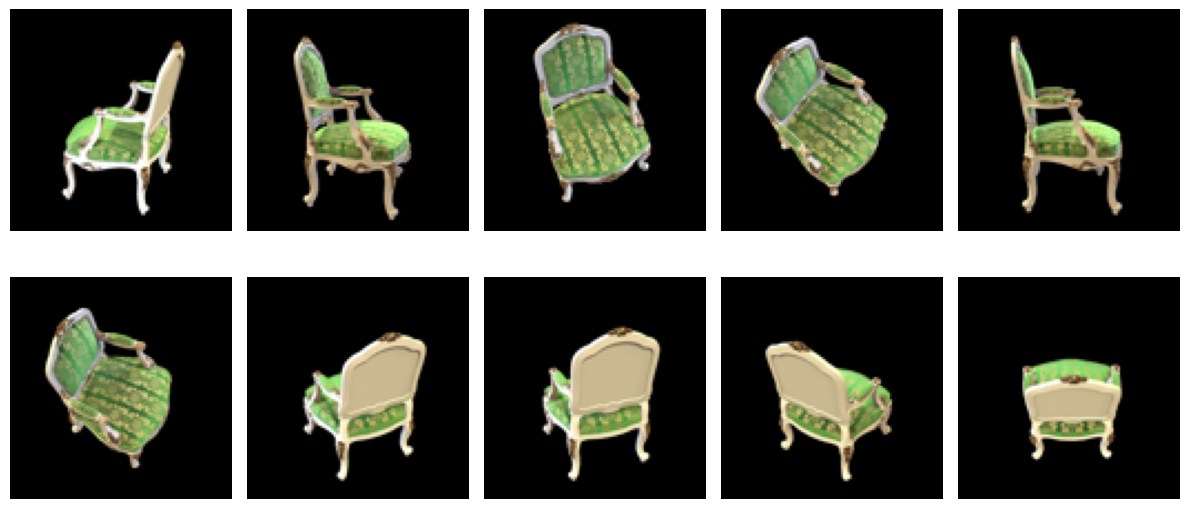

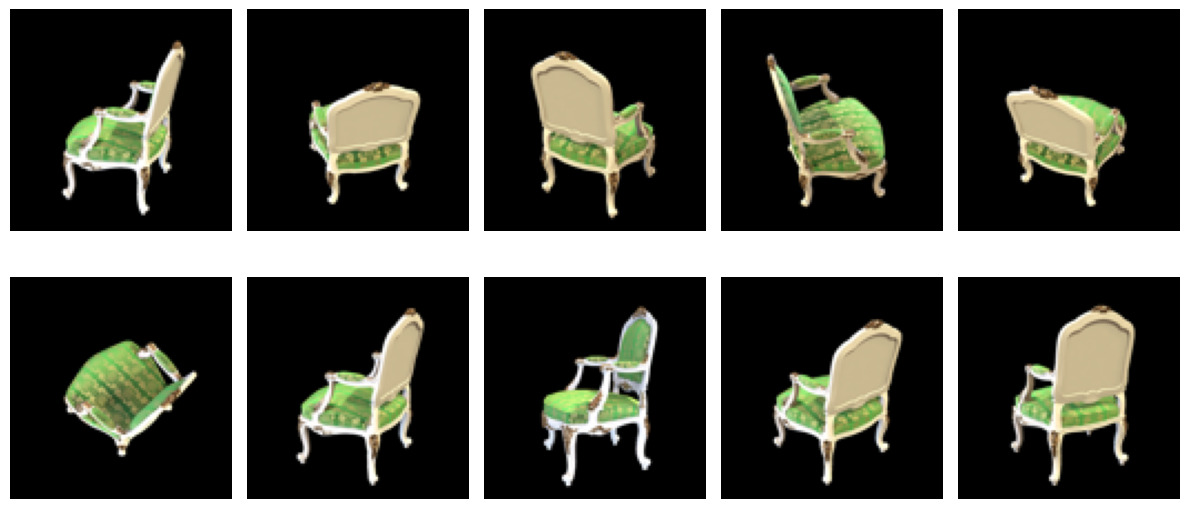

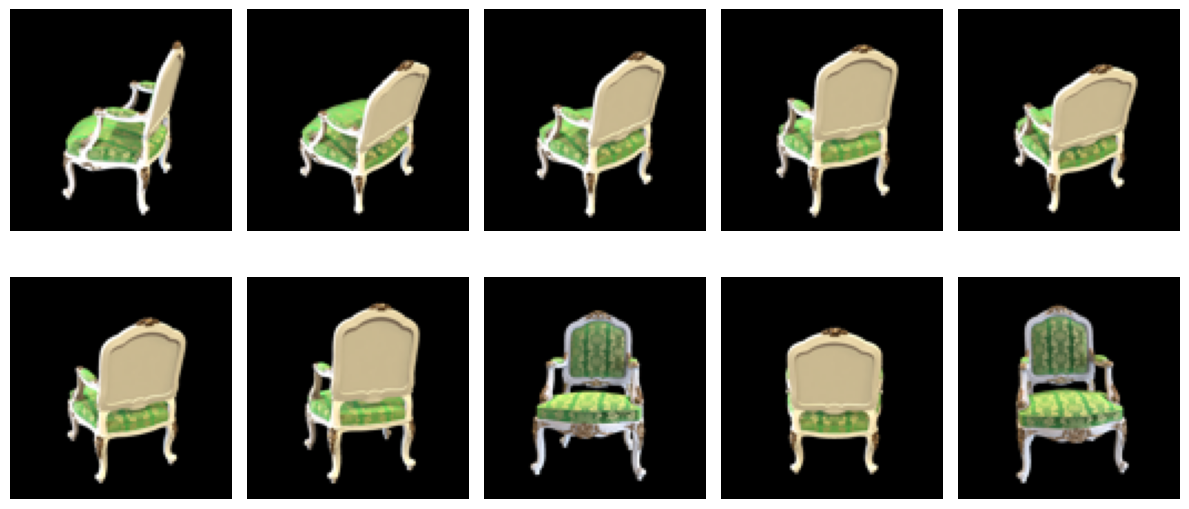

In [29]:
# Lists to log metrics etc.
psnr_vals_dict = {}
lpips_vals_dict = {}
ssim_vals_dict = {}

k = 10
strategies = ["random", "fvs", "min_iou_3d"]

for strategy in strategies:
    
    psnr_vals, lpips_vals, ssim_vals = [], [], []
    training_images, training_tforms = select_frames_from_baseline(images, focal_length, tform_cam2world, strategy ,k)
    
    model = VeryTinyNerfModel(num_encoding_functions=num_encoding_functions).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    if strategy != "full":
        fig, axs = plt.subplots(2, 5, figsize=(12, 6))
        # Loop through all axes and images
        for ax, image in zip(axs.ravel(), training_images):
            ax.imshow(image.detach().cpu().numpy(), cmap='viridis')  # You can change the colormap if needed
            ax.axis('off')  # Turn off axis

        plt.tight_layout()
        if experiment_data_type == "tiny_nerf":
            plt.savefig(f"{logs_path}/chosen_frames_using_{strategy}_strategy.png")
        else:
            #create folder for nerf test subject
            if not os.path.exists(f"{logs_path}"):
                os.makedirs(f"{logs_path}")
            plt.savefig(f"{logs_path}/chosen_frames_using_{strategy}_strategy.png")
        plt.show()

    for j in range(num_iters):

        # Randomly pick an image as the target.
        for training_img, training_pose in zip(training_images, training_tforms):
            
            # Run one iteration of TinyNeRF and get the rendered RGB image.
            rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                                    training_pose, near_thresh,
                                                    far_thresh, depth_samples_per_ray,
                                                    encode, get_minibatches, chunksize, model)

            # Compute mean-squared error between the predicted and target images. Backprop!
            loss = torch.nn.functional.mse_loss(rgb_predicted, training_img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        avg_psnr, avg_lpips, avg_ssim = [], [], []
        with torch.no_grad():
            for testimg, testpose in zip(testimgs, testposes):
                avg_psnr = []
                rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                                        testpose, near_thresh,
                                                        far_thresh, depth_samples_per_ray,
                                                        encode, get_minibatches, chunksize, model)
                loss = torch.nn.functional.mse_loss(rgb_predicted, testimg)
                psnr = -10. * torch.log10(loss)
                avg_psnr.append(psnr.item())

                lpips_loss = calculate_lpips(rgb_predicted, testimg, device)
                avg_lpips.append(lpips_loss)

                rgb_predicted_cpu = rgb_predicted.cpu().detach().numpy()
                testimg_cpu = testimg.cpu().detach().numpy()
                ssim_loss = calculate_ssim(rgb_predicted_cpu, testimg_cpu)
                avg_ssim.append(ssim_loss)

        psnr_vals.append(np.average(avg_psnr))
        lpips_vals.append(np.average(avg_lpips))
        ssim_vals.append(np.average(avg_ssim))

    psnr_vals_dict[strategy] = psnr_vals
    lpips_vals_dict[strategy] = lpips_vals
    ssim_vals_dict[strategy] = ssim_vals
    torch.save(model.state_dict(), f"{logs_path}/models/model_{strategy}.pth")

if not os.path.exists(f'{logs_path}/results'):
    os.makedirs(f'{logs_path}/results')
np.save(f'{logs_path}/results/psnr_vals_dict_baseline.npy', psnr_vals_dict)
np.save(f'{logs_path}/results/lpips_vals_dict_baseline.npy', lpips_vals_dict)
np.save(f'{logs_path}/results/ssim_vals_dict_baseline.npy', ssim_vals_dict)

In [10]:
# psnr_vals_dict = np.load(f'{logs_path}/psnr_vals_dict.npy', allow_pickle=True).item()
# lpips_vals_dict = np.load(f'{logs_path}/lpips_vals_dict.npy', allow_pickle=True).item()
# ssim_vals_dict = np.load(f'{logs_path}/ssim_vals_dict.npy', allow_pickle=True).item()

# # Plot PSNR, SSIM, and LPIPS in subplots
# plt.figure(figsize=(15, 4))

# plt.subplot(131)
# plt.plot(psnr_vals_dict[strategies[0]], label="PSNR for " + strategies[0] + ": {:.4f}".format(psnr_vals_dict[strategies[0]][-1]))
# plt.plot(psnr_vals_dict[strategies[1]], label="PSNR for " + strategies[1] + ": {:.4f}".format(psnr_vals_dict[strategies[1]][-1]))
# plt.plot(psnr_vals_dict[strategies[2]], label="PSNR for " + strategies[2] + ": {:.4f}".format(psnr_vals_dict[strategies[2]][-1]))
# #plt.plot(psnr_vals_dict[strategies[3]], label="PSNR for " + strategies[3] + ": {:.4f}".format(psnr_vals_dict[strategies[3]][-1]))
# #plt.plot(psnr_vals_dict[strategies[4]], label="PSNR for " + strategies[4] + ": {:.4f}".format(psnr_vals_dict[strategies[4]][-1]))
# plt.legend()
# plt.title("PSNR")

# plt.subplot(132)
# plt.plot(lpips_vals_dict[strategies[0]], label="LPIPS for " + strategies[0] + ": {:.4f}".format(lpips_vals_dict[strategies[0]][-1]))
# plt.plot(lpips_vals_dict[strategies[1]], label="LPIPS for " + strategies[1] + ": {:.4f}".format(lpips_vals_dict[strategies[1]][-1]))
# plt.plot(lpips_vals_dict[strategies[2]], label="LPIPS for " + strategies[2] + ": {:.4f}".format(lpips_vals_dict[strategies[2]][-1]))
# # plt.plot(lpips_vals_dict[strategies[3]], label="LPIPS for " + strategies[3] + ": {:.4f}".format(lpips_vals_dict[strategies[3]][-1]))
# # plt.plot(lpips_vals_dict[strategies[4]], label="LPIPS for " + strategies[4] + ": {:.4f}".format(lpips_vals_dict[strategies[4]][-1]))
# plt.legend()
# plt.title("LPIPS")

# plt.subplot(133)
# plt.plot(ssim_vals_dict[strategies[0]], label="SSIM for " + strategies[0] + ": {:.4f}".format(ssim_vals_dict[strategies[0]][-1]))
# plt.plot(ssim_vals_dict[strategies[1]], label="SSIM for " + strategies[1] + ": {:.4f}".format(ssim_vals_dict[strategies[1]][-1]))
# plt.plot(ssim_vals_dict[strategies[2]], label="SSIM for " + strategies[2] + ": {:.4f}".format(ssim_vals_dict[strategies[2]][-1]))
# # plt.plot(ssim_vals_dict[strategies[3]], label="SSIM for " + strategies[3] + ": {:.4f}".format(ssim_vals_dict[strategies[3]][-1]))
# # plt.plot(ssim_vals_dict[strategies[4]], label="SSIM for " + strategies[4] + ": {:.4f}".format(ssim_vals_dict[strategies[4]][-1]))
# plt.legend()
# plt.title("SSIM")

# plt.tight_layout()
# if experiment_data_type == "tiny_nerf":
#     plt.savefig(f"{logs_path}/results.png")
# else:
#     #create folder for nerf test subject    
#     if not os.path.exists(f"{logs_path}/{nerf_test_subject}"):
#         os.makedirs(f"{logs_path}/{nerf_test_subject}")
#     plt.savefig(f"{logs_path}/{nerf_test_subject}/results.png")
# plt.show()

In [11]:
# model = VeryTinyNerfModel(num_encoding_functions=num_encoding_functions).to(device)
# model.load_state_dict(torch.load(f"{logs_path}/models/model_full.pth"))
# print("Reconstructed Test Images")
# for testimg, testpose in zip(testimgs, testposes):
#     rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
#                                             testpose, near_thresh,
#                                             far_thresh, depth_samples_per_ray,
#                                             encode, get_minibatches, chunksize, model)
#     plt.figure(figsize=(10, 4))
#     plt.subplot(121)
#     plt.imshow(testimg.detach().cpu().numpy())
#     plt.title("Original Image")
#     plt.subplot(122)
#     plt.imshow(rgb_predicted.detach().cpu().numpy())
#     plt.title("Predicted Image")
#     plt.axis('off')